# Generalities for DAEs and VAEs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network classes

* Deterministic auto-encoder (DAE)
* Variational auto-encoder (VAE)


In [75]:
# Deterministic Auto-Encoder (DAE)
class DAE(nn.Module):

    # declare layers
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    # encoder: one ReLU hidden layer of 400 nodes, one Linear output layer of 20 nodes
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h)

    # decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    # forward: encoder followed by decoder
    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

# Variational Auto-Encoder (VAE)     
class VAE(nn.Module):

    # declare layers
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400,20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        


    # Encoder: one ReLU hidden layer of 400 nodes, two Linear output layers of 20 nodes (means and log_variances)
    # Input: image (array of size 784)
    # Output: means (array of size 20), log_variances (array of size 20)
    def encode(self, x):
        h = F.relu(self.fc1(x))
        means = self.fc2(h)
        log_variances = self.fc2(h)
        return means, log_variances

    # Reparameterization:
    #
    # Let eps be samples from a Normal(0,1)
    # Input: means (array of size 20), log_variances (array of size 20)
    # Output: embedding (array of size 20 corresponding to means + eps * exponential(log_variances/2))
    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5*log_variances) # standard deviation
        eps = torch.randn_like(std) # a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1
        embedding = means + (eps * std) # sampling as if coming from the input space
        return embedding

    # Decoder: one ReLU hidden layer of 400 nodes, one sigmoid output layer of 784 nodes
    # Input: embedding (array of size 20)
    # Output: probability of reconstructed image (array of size 784)
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        probabilties = torch.sigmoid(self.fc4(h3))
        return probabilties

    # Function forward: encoder, reparameterize, decoder
    # Input: image
    # Output: probability of reconstructed image, means, log_variances
    def forward(self, x):
        means,log_variances=self.encode(x.view(-1, 784))
        embedding=self.reparameterize(means, log_variances)
        probabilties = self.decode(embedding)
        return probabilties, means, log_variances

# Loss Functions

In [77]:
# DAE Loss Function
# Reconstruction loss: binary cross entropy
#
# Inputs:
#    reconstructed_x: reconstructed image
#    x: image
#
# Output:
#    BCE: binary cross entropy  
#
def dae_loss_function(reconstructed_x, x):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    return BCE

# VAE Loss Function
# Reconstruction loss: binary cross entropy
# KL divergence loss: -0.5 * sum(1 + log_variances - means^2 - exp(log_variances))
#       see Appendix B from VAE paper:
#       Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#       https://arxiv.org/abs/1312.6114
#
# Inputs: 
#    reconstructed_x: reconstructed image
#    x: image
#    means: array of size 20
#    log_variances: array of size 20
#
# Outputs:
#    total_loss: binary cross entropy + KL divergence (scalar)
#    BCE: binary cross entropy (scalar)
#
def vae_loss_function(reconstructed_x, x, means, log_variances):
    BCE = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum') 
    KLD = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())
    total_loss=BCE + KLD
    return total_loss, BCE


# Training

In [83]:
# DAE Training
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#    optimizer: DAE optimizer
#
# Outputs:
#    average_train_BCE: binary cross entropy (scalar)
#
def dae_train(epoch, model, optimizer):
    train_BCE = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = dae_loss_function(recon_batch, data)
        loss.backward()
        train_BCE += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_BCE))
    return average_train_BCE

# VAE Training
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#    optimizer: VAE optimizer
#
# Outputs:
#    average_train_loss: binary cross entropy + KL divergence (scalar)
#    average_train_BCE: binary cross entropy (scalar)
#
def vae_train(epoch, model, optimizer):
    train_BCE = 0
    train_loss=0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, means, log_variances = model(data)
        total_loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
        total_loss.backward()
        train_BCE += BCE
        train_loss += total_loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                total_loss.item() / len(data)))

    average_train_BCE = train_BCE / len(train_loader.dataset)
    average_train_loss = train_loss / len(train_loader.dataset)

    print('====> Epoch: {} Average BCE: {:.4f}'.format(
          epoch, average_train_BCE))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_train_loss))
    return average_train_loss, average_train_BCE



# Testing

In [84]:
# DAE Test
#
# Inputs:
#    epoch: epoch #
#    model: DAE neural network
#
# Outputs:
#    average_test_BCE: binary cross entropy (scalar)
#
def dae_test(epoch, model):
    model.eval()
    test_BCE = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_BCE += dae_loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(average_test_BCE))
    return average_test_BCE

# VAE Test
#
# Inputs:
#    epoch: epoch #
#    model: VAE neural network
#
# Outputs:
#    average_test_loss: binary cross entropy + KL divergence (scalar)
#    average_test_BCE: binary cross entropy (scalar)
#
def vae_test(epoch, model):
    model.eval()
    test_BCE = 0
    test_loss=0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, means, log_variances= model(data)
            total_loss, BCE = vae_loss_function(recon_batch, data, means, log_variances)
            test_BCE += BCE
            test_loss += total_loss.item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
                print('Sample of reconstructed images (top row are targets and bottom row are reconstructions)')
                display(Image('results/reconstruction_' + str(epoch) + '.png'))

    average_test_BCE = test_BCE / len(test_loader.dataset)
    average_test_loss = test_loss / len(test_loader.dataset)

    print('====> Test set BCE: {:.4f}'.format(average_test_BCE))
    print('====> Test set loss: {:.4f}'.format(average_test_loss))

    return average_test_loss, average_test_BCE


# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.275391
Train Epoch: 1 [12800/60000 (21%)]	Loss: 160.394470
Train Epoch: 1 [25600/60000 (43%)]	Loss: 118.844307
Train Epoch: 1 [38400/60000 (64%)]	Loss: 93.767624
Train Epoch: 1 [51200/60000 (85%)]	Loss: 90.876770
====> Epoch: 1 Average loss: 131.7569
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


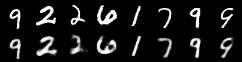

====> Test set loss: 87.3641
Sample of generated images


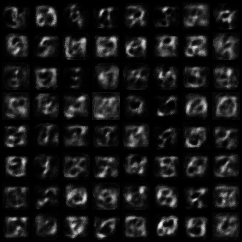



Train Epoch: 2 [0/60000 (0%)]	Loss: 89.124519
Train Epoch: 2 [12800/60000 (21%)]	Loss: 85.695290
Train Epoch: 2 [25600/60000 (43%)]	Loss: 79.821747
Train Epoch: 2 [38400/60000 (64%)]	Loss: 80.675453
Train Epoch: 2 [51200/60000 (85%)]	Loss: 78.678085
====> Epoch: 2 Average loss: 82.3951
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


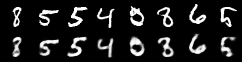

====> Test set loss: 77.7460
Sample of generated images


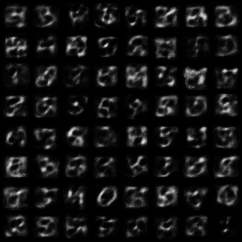



Train Epoch: 3 [0/60000 (0%)]	Loss: 76.056030
Train Epoch: 3 [12800/60000 (21%)]	Loss: 74.347733
Train Epoch: 3 [25600/60000 (43%)]	Loss: 76.782692
Train Epoch: 3 [38400/60000 (64%)]	Loss: 79.745331
Train Epoch: 3 [51200/60000 (85%)]	Loss: 76.781021
====> Epoch: 3 Average loss: 76.8056
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


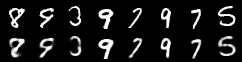

====> Test set loss: 74.5439
Sample of generated images


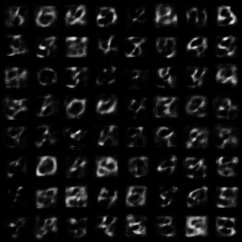



Train Epoch: 4 [0/60000 (0%)]	Loss: 76.744102
Train Epoch: 4 [12800/60000 (21%)]	Loss: 76.781540
Train Epoch: 4 [25600/60000 (43%)]	Loss: 78.346306
Train Epoch: 4 [38400/60000 (64%)]	Loss: 74.216034
Train Epoch: 4 [51200/60000 (85%)]	Loss: 76.450089
====> Epoch: 4 Average loss: 74.1358
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


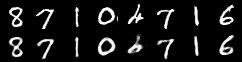

====> Test set loss: 72.6024
Sample of generated images


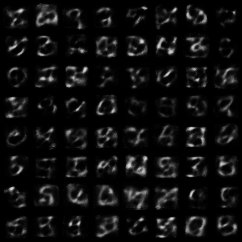



Train Epoch: 5 [0/60000 (0%)]	Loss: 69.806854
Train Epoch: 5 [12800/60000 (21%)]	Loss: 74.949219
Train Epoch: 5 [25600/60000 (43%)]	Loss: 69.389740
Train Epoch: 5 [38400/60000 (64%)]	Loss: 76.352570
Train Epoch: 5 [51200/60000 (85%)]	Loss: 70.834198
====> Epoch: 5 Average loss: 72.3541
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


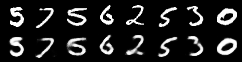

====> Test set loss: 71.3306
Sample of generated images


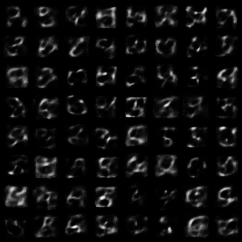



Train Epoch: 6 [0/60000 (0%)]	Loss: 72.002075
Train Epoch: 6 [12800/60000 (21%)]	Loss: 69.668861
Train Epoch: 6 [25600/60000 (43%)]	Loss: 74.942291
Train Epoch: 6 [38400/60000 (64%)]	Loss: 72.326904
Train Epoch: 6 [51200/60000 (85%)]	Loss: 68.108536
====> Epoch: 6 Average loss: 71.0703
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


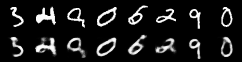

====> Test set loss: 70.3388
Sample of generated images


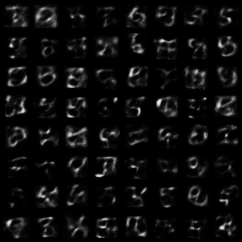



Train Epoch: 7 [0/60000 (0%)]	Loss: 70.372795
Train Epoch: 7 [12800/60000 (21%)]	Loss: 68.588440
Train Epoch: 7 [25600/60000 (43%)]	Loss: 71.153404
Train Epoch: 7 [38400/60000 (64%)]	Loss: 67.354630
Train Epoch: 7 [51200/60000 (85%)]	Loss: 66.781418
====> Epoch: 7 Average loss: 70.0537
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


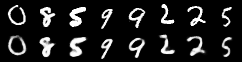

====> Test set loss: 69.5075
Sample of generated images


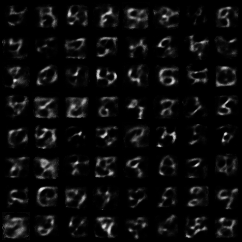



Train Epoch: 8 [0/60000 (0%)]	Loss: 70.880768
Train Epoch: 8 [12800/60000 (21%)]	Loss: 72.985687
Train Epoch: 8 [25600/60000 (43%)]	Loss: 69.050758
Train Epoch: 8 [38400/60000 (64%)]	Loss: 69.133957
Train Epoch: 8 [51200/60000 (85%)]	Loss: 69.031326
====> Epoch: 8 Average loss: 69.2764
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


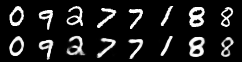

====> Test set loss: 68.8228
Sample of generated images


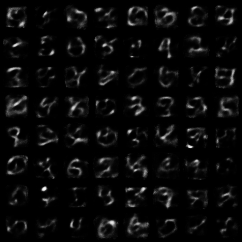



Train Epoch: 9 [0/60000 (0%)]	Loss: 68.558014
Train Epoch: 9 [12800/60000 (21%)]	Loss: 65.695053
Train Epoch: 9 [25600/60000 (43%)]	Loss: 71.536552
Train Epoch: 9 [38400/60000 (64%)]	Loss: 67.143349
Train Epoch: 9 [51200/60000 (85%)]	Loss: 65.860504
====> Epoch: 9 Average loss: 68.6289
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


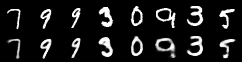

====> Test set loss: 68.2489
Sample of generated images


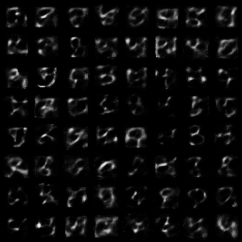



Train Epoch: 10 [0/60000 (0%)]	Loss: 65.659653
Train Epoch: 10 [12800/60000 (21%)]	Loss: 67.241631
Train Epoch: 10 [25600/60000 (43%)]	Loss: 67.404449
Train Epoch: 10 [38400/60000 (64%)]	Loss: 68.824631
Train Epoch: 10 [51200/60000 (85%)]	Loss: 68.596809
====> Epoch: 10 Average loss: 68.1051
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


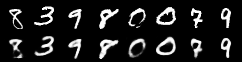

====> Test set loss: 67.8479
Sample of generated images


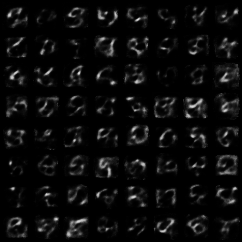



Train Epoch: 1 [0/60000 (0%)]	Loss: 547.113831
Train Epoch: 1 [12800/60000 (21%)]	Loss: 188.550323
Train Epoch: 1 [25600/60000 (43%)]	Loss: 162.387344
Train Epoch: 1 [38400/60000 (64%)]	Loss: 159.068542
Train Epoch: 1 [51200/60000 (85%)]	Loss: 161.331436
====> Epoch: 1 Average BCE: 165.1338
====> Epoch: 1 Average loss: 179.9448
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


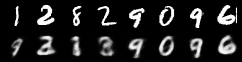

====> Test set BCE: 130.9037
====> Test set loss: 152.0776
Sample of generated images


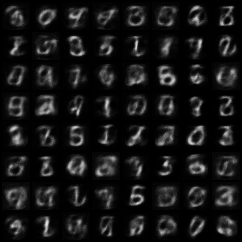



Train Epoch: 2 [0/60000 (0%)]	Loss: 149.585999
Train Epoch: 2 [12800/60000 (21%)]	Loss: 148.069366
Train Epoch: 2 [25600/60000 (43%)]	Loss: 141.115036
Train Epoch: 2 [38400/60000 (64%)]	Loss: 153.160965
Train Epoch: 2 [51200/60000 (85%)]	Loss: 143.429321
====> Epoch: 2 Average BCE: 124.6830
====> Epoch: 2 Average loss: 147.3847
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


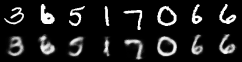

====> Test set BCE: 118.5855
====> Test set loss: 142.8705
Sample of generated images


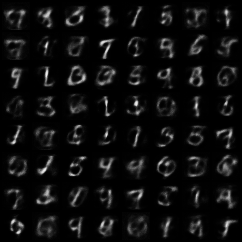



Train Epoch: 3 [0/60000 (0%)]	Loss: 145.263062
Train Epoch: 3 [12800/60000 (21%)]	Loss: 143.482117
Train Epoch: 3 [25600/60000 (43%)]	Loss: 141.980865
Train Epoch: 3 [38400/60000 (64%)]	Loss: 134.557571
Train Epoch: 3 [51200/60000 (85%)]	Loss: 139.966980
====> Epoch: 3 Average BCE: 116.9414
====> Epoch: 3 Average loss: 141.6286
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


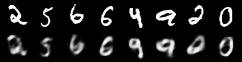

====> Test set BCE: 112.5909
====> Test set loss: 139.1628
Sample of generated images


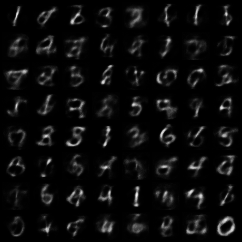



Train Epoch: 4 [0/60000 (0%)]	Loss: 135.696777
Train Epoch: 4 [12800/60000 (21%)]	Loss: 135.277222
Train Epoch: 4 [25600/60000 (43%)]	Loss: 140.525604
Train Epoch: 4 [38400/60000 (64%)]	Loss: 134.140594
Train Epoch: 4 [51200/60000 (85%)]	Loss: 137.721634
====> Epoch: 4 Average BCE: 113.1330
====> Epoch: 4 Average loss: 138.6666
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


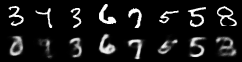

====> Test set BCE: 110.9750
====> Test set loss: 137.1057
Sample of generated images


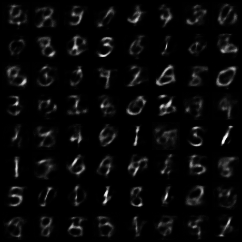



Train Epoch: 5 [0/60000 (0%)]	Loss: 138.710114
Train Epoch: 5 [12800/60000 (21%)]	Loss: 143.262558
Train Epoch: 5 [25600/60000 (43%)]	Loss: 133.733521
Train Epoch: 5 [38400/60000 (64%)]	Loss: 134.309616
Train Epoch: 5 [51200/60000 (85%)]	Loss: 136.535614
====> Epoch: 5 Average BCE: 110.8852
====> Epoch: 5 Average loss: 136.8992
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


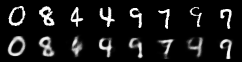

====> Test set BCE: 109.6840
====> Test set loss: 135.7972
Sample of generated images


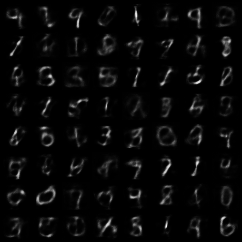



Train Epoch: 6 [0/60000 (0%)]	Loss: 134.922180
Train Epoch: 6 [12800/60000 (21%)]	Loss: 136.809433
Train Epoch: 6 [25600/60000 (43%)]	Loss: 127.024506
Train Epoch: 6 [38400/60000 (64%)]	Loss: 129.803040
Train Epoch: 6 [51200/60000 (85%)]	Loss: 139.565063
====> Epoch: 6 Average BCE: 109.2583
====> Epoch: 6 Average loss: 135.5779
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


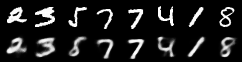

====> Test set BCE: 106.8937
====> Test set loss: 134.3301
Sample of generated images


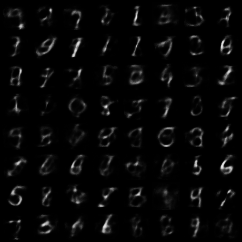



Train Epoch: 7 [0/60000 (0%)]	Loss: 132.405869
Train Epoch: 7 [12800/60000 (21%)]	Loss: 140.440445
Train Epoch: 7 [25600/60000 (43%)]	Loss: 130.440689
Train Epoch: 7 [38400/60000 (64%)]	Loss: 134.174576
Train Epoch: 7 [51200/60000 (85%)]	Loss: 135.460464
====> Epoch: 7 Average BCE: 108.1791
====> Epoch: 7 Average loss: 134.7445
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


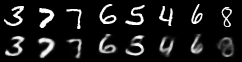

====> Test set BCE: 106.1275
====> Test set loss: 133.5205
Sample of generated images


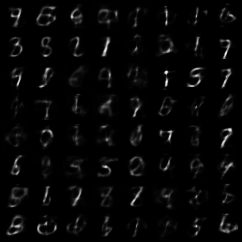



Train Epoch: 8 [0/60000 (0%)]	Loss: 129.384598
Train Epoch: 8 [12800/60000 (21%)]	Loss: 135.380615
Train Epoch: 8 [25600/60000 (43%)]	Loss: 130.288147
Train Epoch: 8 [38400/60000 (64%)]	Loss: 132.305023
Train Epoch: 8 [51200/60000 (85%)]	Loss: 130.051575
====> Epoch: 8 Average BCE: 107.1846
====> Epoch: 8 Average loss: 133.8999
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


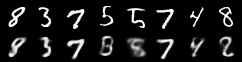

====> Test set BCE: 105.2225
====> Test set loss: 133.0718
Sample of generated images


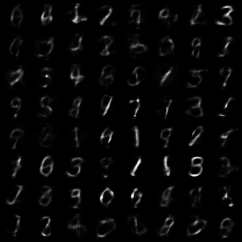



Train Epoch: 9 [0/60000 (0%)]	Loss: 132.087463
Train Epoch: 9 [12800/60000 (21%)]	Loss: 133.676392
Train Epoch: 9 [25600/60000 (43%)]	Loss: 126.335114
Train Epoch: 9 [38400/60000 (64%)]	Loss: 133.926758
Train Epoch: 9 [51200/60000 (85%)]	Loss: 127.531799
====> Epoch: 9 Average BCE: 106.4756
====> Epoch: 9 Average loss: 133.3624
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


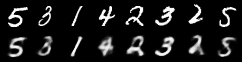

====> Test set BCE: 104.7690
====> Test set loss: 132.5273
Sample of generated images


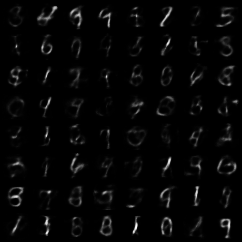



Train Epoch: 10 [0/60000 (0%)]	Loss: 134.492584
Train Epoch: 10 [12800/60000 (21%)]	Loss: 133.828308
Train Epoch: 10 [25600/60000 (43%)]	Loss: 132.666534
Train Epoch: 10 [38400/60000 (64%)]	Loss: 132.908875
Train Epoch: 10 [51200/60000 (85%)]	Loss: 136.229858
====> Epoch: 10 Average BCE: 105.8852
====> Epoch: 10 Average loss: 132.8713
Sample of reconstructed images (top row are targets and bottom row are reconstructions)


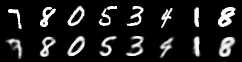

====> Test set BCE: 104.1242
====> Test set loss: 132.1960
Sample of generated images


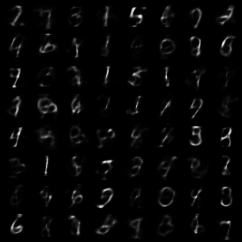

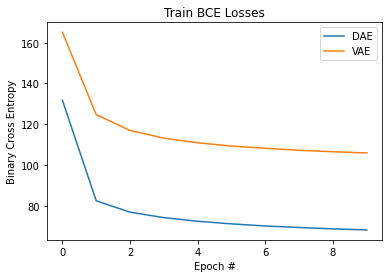

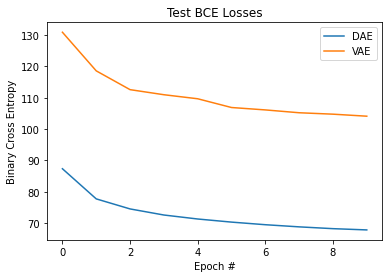

In [86]:
# train and test DAE
epochs = 10
dae_average_train_BCE = []
dae_average_test_BCE = []
dae_model = DAE().to(device)
dae_optimizer = optim.Adam(dae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_BCE = dae_train(epoch, dae_model, dae_optimizer)
    dae_average_train_BCE.append(average_train_BCE)
    average_test_BCE = dae_test(epoch, dae_model)
    dae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = dae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# train and test VAE
epochs = 10
vae_average_train_losses = []
vae_average_train_BCE = []
vae_average_test_losses = []
vae_average_test_BCE = []
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    average_train_loss, average_train_BCE = vae_train(epoch, vae_model, vae_optimizer)
    vae_average_train_losses.append(average_train_loss)
    vae_average_train_BCE.append(average_train_BCE)
    average_test_loss, average_test_BCE = vae_test(epoch, vae_model)
    vae_average_test_losses.append(average_test_loss)
    vae_average_test_BCE.append(average_test_BCE)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train BCE Losses
plt.plot(dae_average_train_BCE)
plt.plot(vae_average_train_BCE)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

# Plot Test BCE Losses
plt.plot(dae_average_test_BCE)
plt.plot(vae_average_test_BCE)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['DAE','VAE'], loc='upper right')
plt.show()

We can see from the graph: BCE loss which is also called binary cross-entropy for VAE is higher than that of DAE, also reconstructed digits from DAE is much closer to true digits than it is produced from VAE. 

However image quality for VAE is better than that of DAE. As epoch increases, both DAE and VAE generated images got lower quality. I notice VAE tends to generate simple digits such as 1's and 9's especially when epoch is higher, but DAE generate images contains more variety of digits including more complex digits like 8's, but very blurry and unclear. For VAE, most of time, digits are blank in some part, and only in one part of the image has clear digits, but for DAE, most of digits are shown and not blank but just very blurry, and it is hard to tell which digit it is. 

Binary cross-entropy is mathematically equals to negative of all log probablities of predicting the true labels, and we average all these -log(prob)'s. BCE measures how predicted pixcel (0 or 1) is different than true pixel (0 or 1) on average in a picture. For DAE we simply apply several layers of summary from previous layers informaiton (encoding), and then try to reconstruct a more complex information from latent layer until we restore same number of pixels. However, VAE utilized a approximated Normal distribution in place of true latent distribution f(h|x). We literaly add some noise to make a smiliar but different images, sp predicted y's could be very different form true y, so loss for VAE is higher than DAE.This is why reconstructed images are much clear for DAE compared to this from VAE simply becasue DAE is restoration (reconstruction) and VAE is generating similiar but different images.  